In [1]:
import sys
import torch

sys.path.append("/home/usc/ie/dcr/hk/ml/hit_ana_gnn/utils")
sys.path.append("/home/usc/ie/dcr/hk/ml/hit_ana_gnn/networks")

from data_loader import createDataFrame
from data_loader import addLabel
from data_loader import graphDataset

from plot_utils import visualize_graph

from architectures import GAT

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Wider Cells
from IPython.display import display, HTML, Markdown
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [2]:
npz = '/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk/WCSim/install/nicfVec_5kHzDR00-1350_7Th200ns-400+950.npz'
nevents = 30000

In [3]:
df = createDataFrame(npz, nevents)
df = addLabel(df)

df.head()

,event_id,digi_hit_pmt,digi_hit_charge,digi_hit_time,digi_hit_trigger,digi_hit_x,digi_hit_y,digi_hit_z,digi_hit_truehit_parent_trackID,digi_hit_truehit_creator,digi_hit_truehit_times,digi_hit_r,label
1,1,1494,1.086721,2116.300049,0,-72.398308,81.252716,-139.803162,[-1],[darkNoise],[1167.1127200126648],177.167838,0
2,1,727,1.050667,2030.5,0,105.411903,-107.78112,-111.376305,[-1],[darkNoise],[1081.1512470245361],187.438311,0
3,1,892,1.534663,1815.900024,0,-120.387672,-108.205215,101.455643,[-1],[darkNoise],[866.1449700593948],191.036143,0
4,1,1282,0.529772,1725.300049,0,-123.728966,-138.782364,71.386963,[-1],[darkNoise],[775.2003014087677],199.161994,0
5,1,949,0.813465,1597.900024,0,-13.386964,-138.782364,50.271034,[-1],[darkNoise],[648.6538141965866],148.212456,0


In [4]:
gnnDataset = graphDataset(file=npz, df=df, num_neigh=5, num_classes=2, directed=False, classic=True, all_connected=False)

Skipping event 2919 due to error: Repeated hit (105.43885, 66.31584, -111.32409) in event 2919
Skipping event 3419 due to error: Repeated hit (116.38686, -55.863213, -105.45645) in event 3419
Skipping event 5178 due to error: Repeated hit (147.98482, 1.9567119, 52.81901) in event 5178
Skipping event 5800 due to error: Repeated hit (45.582325, 73.52375, 150.98235) in event 5800
Skipping event 5821 due to error: Repeated hit (-141.98975, -86.90921, 67.29238) in event 5821
Skipping event 5863 due to error: Repeated hit (60.0557, -84.81039, -144.98727) in event 5863
Skipping event 7036 due to error: Repeated hit (139.01064, -42.47625, -74.31164) in event 7036
Skipping event 13397 due to error: Repeated hit (-99.99125, -42.47625, 121.852066) in event 13397
Skipping event 18038 due to error: Repeated hit (-151.9463, -100.47625, 2.476045e-14) in event 18038
Skipping event 20313 due to error: Repeated hit (144.79228, -100.47625, -50.9662) in event 20313
Skipping event 20783 due to error: Repea

In [9]:
graph = gnnDataset[7]  # Get the first graph object.

print(graph)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {graph.num_nodes}')
print(f'Number of edges: {graph.num_edges}')
print(f'Average node degree: {graph.num_edges / graph.num_nodes:.2f}')
print(f'Has isolated nodes: {graph.has_isolated_nodes()}')
print(f'Has self-loops: {graph.has_self_loops()}')
print(f'Is undirected: {graph.is_undirected()}')

Data(x=[41, 2], edge_index=[2, 205], edge_attr=[205, 1], y=[41], edge_weight=[205], num_nodes=41, dataset_id=57, num_features=2, fnum='nicfVec_5kHzDR00-1350_7Th200ns-400+950_event57')
Number of nodes: 41
Number of edges: 205
Average node degree: 5.00
Has isolated nodes: False
Has self-loops: False
Is undirected: False


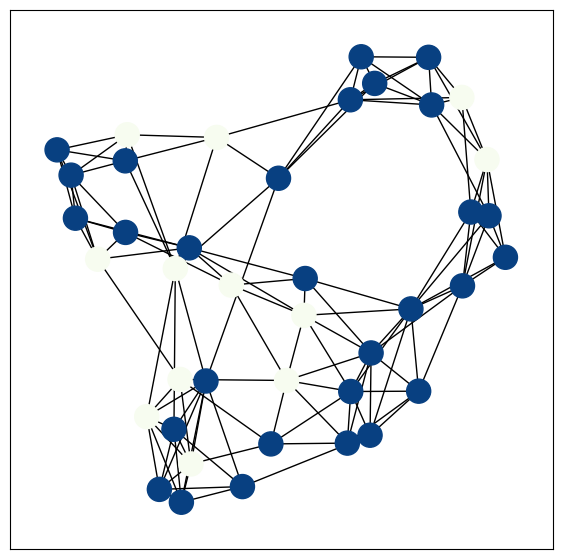

In [10]:
visualize_graph(graph, color=graph.y)

In [11]:
model = GAT(num_features=2, hidden_channels=128, dropout_gat=0.1, dropout_fc=0.2)
print(model)

GAT(
  (conv1): GATConv(2, 128, heads=8)
  (conv2): GATConv(1024, 1, heads=1)
)


In [12]:
from train_utils import train_net
from torch.optim.lr_scheduler import ReduceLROnPlateau
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
train_size = int(0.7 * len(gnnDataset))
val_size   = int(0.15 * len(gnnDataset))
test_size  = len(gnnDataset) - train_size - val_size

train_data, valid_data, test_data = torch.utils.data.random_split(gnnDataset, [train_size, val_size, test_size])

print(f'Number of training graphs: {len(train_data)}')
print(f'Number of validation graphs: {len(valid_data)}')
print(f'Number of test graphs: {len(test_data)}')

Number of training graphs: 1661
Number of validation graphs: 355
Number of test graphs: 357


In [18]:
train_net(nepoch           = 10,
          train_dataset    = train_data,
          valid_dataset    = valid_data,
          train_batch_size = 64,
          valid_batch_size = 64,
          model            = GAT(num_features=2, hidden_channels=128, dropout_gat=0.1, dropout_fc=0.2),
          optimizer        = torch.optim.Adam(model.parameters(), lr=0.01),
          criterion        = torch.nn.BCEWithLogitsLoss(),
          scheduler        = ReduceLROnPlateau(torch.optim.Adam(model.parameters(), lr=0.01), mode='min', factor=0.5, patience=10),
          checkpoint_dir   = "./",
          tensorboard_dir  = "./")

Train Epoch: 0
Training Loss: 0.694886
Validation Loss: 0.694459
Epoch 1/10, LR: 0.010000, Train Loss: 0.6949, Valid Loss: 0.6945
Train Metrics: {'AUROC': 0.4633241891860962, 'Accuracy': 0.4192899167537689, 'Precision': 0.3699132204055786, 'Recall': 0.6717709898948669, 'F1': 0.47710615396499634}
Valid Metrics: {'AUROC': 0.4661576449871063, 'Accuracy': 0.41630297899246216, 'Precision': 0.4155120253562927, 'Recall': 0.8457050323486328, 'F1': 0.5572404861450195}
Train Epoch: 1
Training Loss: 0.694894
Validation Loss: 0.694621
Epoch 2/10, LR: 0.010000, Train Loss: 0.6949, Valid Loss: 0.6946
Train Metrics: {'AUROC': 0.4631895422935486, 'Accuracy': 0.4179039001464844, 'Precision': 0.36613431572914124, 'Recall': 0.6702398657798767, 'F1': 0.47356992959976196}
Valid Metrics: {'AUROC': 0.46329665184020996, 'Accuracy': 0.39985570311546326, 'Precision': 0.39302247762680054, 'Recall': 0.829668402671814, 'F1': 0.5333781838417053}
Train Epoch: 2
Training Loss: 0.694999
Validation Loss: 0.694376
Epoch